# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow to run. At the bottom of the notebook we select our final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [3]:
conda install xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/sheetalsrivastava/opt/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB
    libxgboost-1.7.3           |       hcec6c5f_0         2.3 MB
    py-xgboost-1.7.3           |   py39hecd8cb5_0         216 KB
    xgboost-1.7.3              |   py39hecd8cb5_0          14 KB
    ------------------------------------------------------------
                                           Total:         2.6 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  pkgs/main/osx-64::_py-xgboost-mutex-2.0-cpu_0 None
  libxgboos

In [4]:
conda install catboost

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/sheetalsrivastava/opt/anaconda3

  added / updated specs:
    - catboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.16.0               |       h691a603_2         935 KB
    catboost-1.0.6             |   py39hecd8cb5_1        14.0 MB
    expat-2.4.9                |       he9d5cce_0         127 KB
    font-ttf-dejavu-sans-mono-2.37|       hd3eb1b0_0         335 KB
    font-ttf-inconsolata-2.001 |       hcb22688_0          83 KB

In [23]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [24]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(96397, 42)
CPU times: user 322 ms, sys: 66 ms, total: 388 ms
Wall time: 411 ms


,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60,...,Card_Merchdesc_Zip_med_30,card_merch_med_0,Card_Merchnum_Zip_med_0,card_zip3_med_0,amount_cat,state_des_avg_3,Merchnum_desc_max_0,card_merch_total_30,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,1,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,2,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,3,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,1,3.62,3.62,3.62,4,0
4,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,1,3.62,3.62,7.24,5,0


In [25]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_merch_total_14',
 'card_zip3_max_14',
 'card_merch_avg_14',
 'Card_Merchdesc_Zip_med_14',
 'Card_Merchdesc_Zip_max_60',
 'Card_Merchnum_Zip_avg_60',
 'Card_Merchnum_desc_avg_60',
 'Merchdesc_dow_avg_30',
 'Card_Merchnum_desc_med_0',
 'Card_Merchdesc_max_60']

In [26]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [27]:
vars.shape

(96397, 12)

In [28]:
vars['Fraud'].sum()

1059

In [29]:
vars.head(10)

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
5,6,0,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67
6,7,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
7,8,0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [30]:
vars.shape

(96397, 12)

In [31]:
vars.describe()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,769.967286,529.353162,401.927811,394.564839,551.295774,404.503353,404.444849,396.465357,393.500463,552.096524
std,27945.003883,0.104236,4168.214517,1086.568630,790.425618,783.344833,1104.370845,778.326998,778.414021,696.170708,790.641417,1104.598654
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,77.000000,57.190000,39.990000,39.180000,52.500000,44.900000,44.970000,53.035000,34.900000,52.770000
50%,48365.000000,0.000000,236.920000,212.660000,157.065000,149.970000,223.550000,171.030000,171.000000,200.000000,140.000000,224.300000
75%,72578.000000,0.000000,676.860000,609.000000,452.940000,438.450000,658.000000,472.000000,472.000000,478.200000,431.550000,659.340000
max,96753.000000,1.000000,306633.410000,47900.000000,28392.840000,28392.840000,47900.000000,28392.840000,28392.840000,28392.840000,28392.840000,47900.000000


In [32]:
# find the row i vars that corresponds to 11/1 (Recnum=84300)
test = vars[vars['Recnum'] > 84295]
test.head(10)

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
83966,84296,0,789.32,609.34,394.660,394.660,609.34,394.660000,394.660000,271.69250,394.66,609.34
83967,84297,0,235.00,235.00,235.000,235.000,235.00,235.000000,235.000000,235.00000,235.00,235.00
83968,84298,0,600.00,600.00,600.000,600.000,600.00,600.000000,600.000000,600.00000,600.00,600.00
83969,84299,0,30.00,30.00,30.000,30.000,365.32,197.660000,197.660000,294.10400,30.00,365.32
83970,84300,0,182.00,182.00,182.000,182.000,182.00,182.000000,182.000000,182.00000,182.00,182.00
83971,84301,0,399.61,225.00,199.805,199.805,225.00,199.805000,199.805000,174.61000,174.61,225.00
83972,84302,0,53.00,206.90,53.000,75.500,659.76,224.701429,224.701429,128.45875,53.00,659.76
83973,84303,0,25.00,531.25,25.000,25.000,28.48,26.740000,26.740000,25.00000,25.00,28.48
83974,84304,0,97.17,97.17,97.170,97.170,97.17,97.170000,97.170000,97.17000,97.17,97.17
83975,84305,0,6.51,6.51,6.510,6.510,6.51,11.733333,4.500000,6.51000,6.51,6.51


In [33]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [34]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,769.967286,529.353162,401.927811,394.564839,551.295774,404.503353,404.444849,396.465357,393.500463,552.096524
std,4168.214517,1086.568630,790.425618,783.344833,1104.370845,778.326998,778.414021,696.170708,790.641417,1104.598654
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,77.000000,57.190000,39.990000,39.180000,52.500000,44.900000,44.970000,53.035000,34.900000,52.770000
50%,236.920000,212.660000,157.065000,149.970000,223.550000,171.030000,171.000000,200.000000,140.000000,224.300000
75%,676.860000,609.000000,452.940000,438.450000,658.000000,472.000000,472.000000,478.200000,431.550000,659.340000
max,306633.410000,47900.000000,28392.840000,28392.840000,47900.000000,28392.840000,28392.840000,28392.840000,28392.840000,47900.000000


In [35]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [36]:
# use this to cap variables. For some problems it helps
Clip = 10

In [37]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-4.580238e-16,1.642357e-15,9.159462e-15,-1.424971e-15,1.927932e-16,1.083906e-14,1.434370e-15,6.285712e-15,7.526706e-16,3.751579e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.847211e-01,-4.871696e-01,-5.084828e-01,-5.036796e-01,-4.991854e-01,-5.196959e-01,-5.195626e-01,-5.694801e-01,-4.976851e-01,-4.998073e-01
25%,-1.662504e-01,-4.345452e-01,-4.579024e-01,-4.536761e-01,-4.516561e-01,-4.620209e-01,-4.618042e-01,-4.933134e-01,-4.535564e-01,-4.520434e-01
50%,-1.278838e-01,-2.914617e-01,-3.097860e-01,-3.122441e-01,-2.967715e-01,-2.999682e-01,-2.998981e-01,-2.822086e-01,-3.206263e-01,-2.967562e-01
75%,-2.233745e-02,7.330125e-02,6.453762e-02,5.602279e-02,9.661992e-02,8.672017e-02,8.678563e-02,1.174060e-01,4.812490e-02,9.708818e-02
max,7.337997e+01,4.359655e+01,3.541246e+01,3.574195e+01,4.287392e+01,3.595961e+01,3.595567e+01,4.021481e+01,3.541345e+01,4.286435e+01


In [38]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
# oot_recnum=84300
oot_recnum = 83970
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    179
dtype: int64

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [39]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [40]:
alphas = 10**np.linspace(2,9,30)*0.5

In [41]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [42]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

CPU times: user 383 ms, sys: 33 ms, total: 416 ms
Wall time: 458 ms


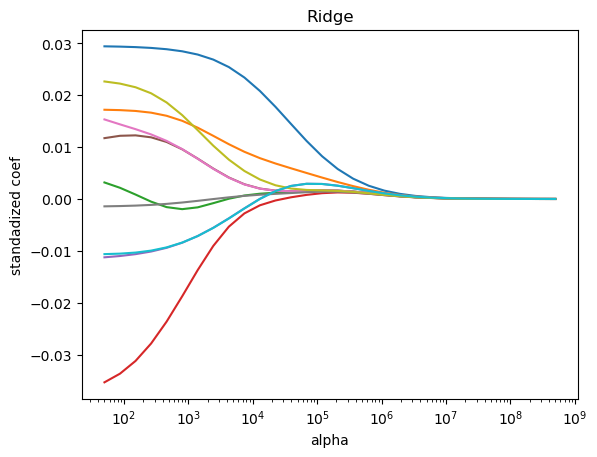

In [43]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [44]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [45]:
# %%time
# # sometimes this cell takes a long time
# lasso = Lasso(max_iter=10000) 
# coefs = [] 
# for a in alphas: 
#     lasso.set_params(alpha=a) 
#     lasso.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(lasso.coef_) 
# # print('Shape:',np.shape(coefs)
# print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


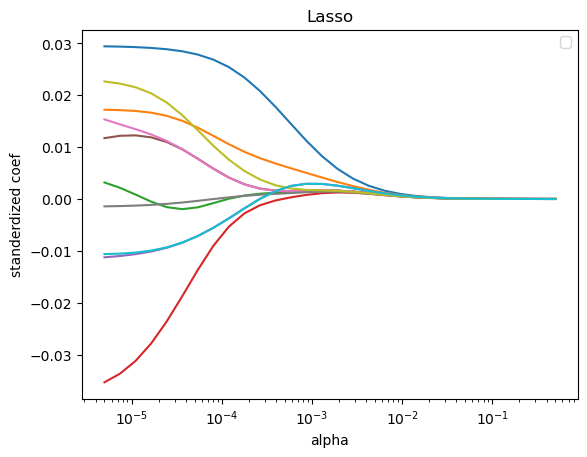

In [46]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [47]:
len(X_trntst.columns)

10

In [48]:
X_trntst_save = X_trntst.copy()

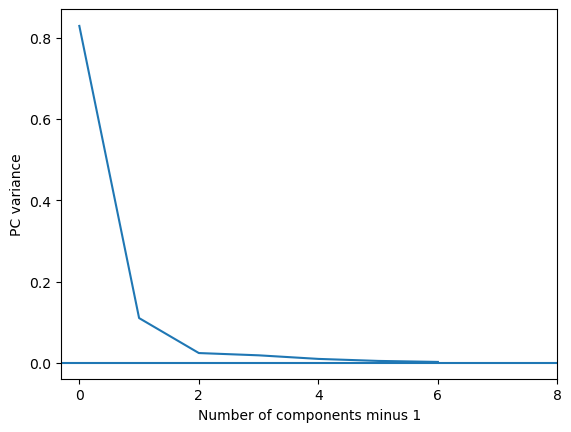

In [49]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [50]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.533139,0.129723,0.014924,0.112895
1,-1.436420,0.109263,0.007556,0.109120
2,-0.924754,0.001023,-0.031418,0.089151
3,-1.533139,0.129723,0.014924,0.112895
4,-1.532957,0.130397,0.014525,0.113179


In [51]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
83970,-0.912542,-0.001561,-0.032348,0.088675
83971,-0.839153,0.052569,-0.009732,0.102327
83972,-0.765169,0.276187,0.410126,-0.256049
83973,-1.304582,0.219003,0.089263,0.097301
83974,-1.207672,0.060872,-0.009868,0.100193


In [52]:
X_trntst.describe()

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000
mean,0.003015,0.001960,0.002997,0.002809,0.002998,0.002315,0.002318,0.002252,0.003263,0.002961
std,1.058833,1.010735,0.999406,0.998680,1.017370,0.996389,0.996397,0.988724,0.999310,1.017333
min,-0.184721,-0.487170,-0.508483,-0.503680,-0.499185,-0.519696,-0.519563,-0.569480,-0.497685,-0.499807
25%,-0.166286,-0.436791,-0.460066,-0.456017,-0.453920,-0.465389,-0.464977,-0.497610,-0.456238,-0.454551
50%,-0.127625,-0.293058,-0.309824,-0.312231,-0.299171,-0.300694,-0.300629,-0.282209,-0.320664,-0.298847
75%,-0.022093,0.074799,0.067220,0.058001,0.098431,0.090575,0.090640,0.119130,0.051436,0.098319
max,73.379967,43.596553,35.412456,35.741954,42.873917,35.959612,35.955667,40.214813,35.413449,42.864350


In [53]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12427.000000,12427.000000,12427.000000,12427.000000
mean,-0.065318,-0.007258,0.004024,-0.004344
std,2.792001,0.646520,0.468131,0.387631
min,-1.545698,-19.899470,-9.303463,-14.058395
25%,-1.293270,-0.103707,-0.097399,-0.052476
50%,-0.821140,0.063737,-0.007941,0.071681
75%,0.193802,0.132513,0.045297,0.107818
max,93.147610,11.290805,15.513500,8.803248


In [54]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [55]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.397000e+04,8.397000e+04,8.397000e+04,8.397000e+04
mean,3.223369e-16,7.055641e-17,-2.151531e-16,9.630659e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.324738e-01,-1.960193e+01,-3.067537e+01,-3.690457e+01
25%,-4.668320e-01,-9.418230e-02,-1.954183e-01,-1.200531e-01
50%,-2.927865e-01,6.671806e-02,-1.164569e-02,1.825460e-01
75%,9.204663e-02,1.316668e-01,6.775808e-02,2.554804e-01
max,3.736512e+01,6.119428e+01,3.728152e+01,3.968844e+01


In [56]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12427.000000,12427.000000,12427.000000,12427.000000
mean,-0.022501,-0.006851,0.008091,-0.009948
std,0.961810,0.610333,0.941264,0.887663
min,-0.532474,-18.785671,-18.706326,-32.193259
25%,-0.445516,-0.097902,-0.195838,-0.120168
50%,-0.282872,0.060170,-0.015967,0.164146
75%,0.066763,0.125096,0.091078,0.246899
max,32.088195,10.658845,31.192750,20.159147


In [57]:
X_trntst_pca.shape

(83970, 4)

In [58]:
X_oot_orig_pca.shape

(12427, 4)

## Subsample the larger class if desired

In [59]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.010479933309515303
(1751, 10) 1751


In [60]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [61]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

### 1) Logistic Regression

In [68]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty='l2', C=0.8, solver='saga', l1_ratio=None)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0 0.6394779771615008 0.6329588014981273 0.5363128491620112


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1 0.6337579617834395 0.6547619047619048 0.5195530726256983


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2 0.6385737439222042 0.6311787072243346 0.5139664804469274


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


3 0.6374367622259697 0.627177700348432 0.5418994413407822


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


4 0.6116504854368932 0.6870229007633588 0.4748603351955307


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


5 0.6166134185303515 0.6811023622047244 0.5027932960893855


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


6 0.6308186195826645 0.6731517509727627 0.5418994413407822


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


7 0.6451077943615257 0.6173285198555957 0.5083798882681564


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


8 0.6285714285714286 0.6385964912280702 0.5083798882681564
9 0.6359143327841845 0.6373626373626373 0.5139664804469274
trn    0.631792
tst    0.648064
oot    0.516201
dtype: float64
CPU times: user 11.2 s, sys: 2.03 s, total: 13.2 s
Wall time: 6.47 s


/Users/sheetalsrivastava/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 2) Decision Tree

In [80]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                   min_samples_leaf=100, min_samples_split=50)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.7708333333333334 0.73828125 0.5698324022346368
1 0.768370607028754 0.7637795275590551 0.5642458100558659
2 0.7651006711409396 0.6971830985915493 0.5754189944134078
3 0.7681159420289855 0.7413127413127413 0.5642458100558659
4 0.7727272727272727 0.6856060606060606 0.5363128491620112
5 0.7571884984025559 0.7598425196850394 0.5418994413407822
6 0.7868852459016393 0.737037037037037 0.553072625698324
7 0.7935483870967742 0.7192307692307692 0.5642458100558659
8 0.7722772277227723 0.7408759124087592 0.5642458100558659
9 0.7704402515723271 0.7459016393442623 0.5418994413407822
trn    0.772549
tst    0.732905
oot    0.557542
dtype: float64
CPU times: user 4.88 s, sys: 36.1 ms, total: 4.92 s
Wall time: 4.92 s


### 3) Random Forest

In [86]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=None, 
                                   min_samples_leaf=200, min_samples_split=100)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.762214983713355 0.7518796992481203 0.5363128491620112
1 0.7504 0.7529411764705882 0.40782122905027934
2 0.7454844006568144 0.7490774907749077 0.4748603351955307
3 0.7601957585644372 0.7415730337078652 0.5418994413407822
4 0.774671052631579 0.7169117647058824 0.4134078212290503
5 0.7266881028938906 0.7558139534883721 0.5083798882681564
6 0.768621236133122 0.7429718875502008 0.3687150837988827
7 0.7675941080196399 0.758364312267658 0.5251396648044693
8 0.7683333333333333 0.75 0.5586592178770949
9 0.7715654952076677 0.7244094488188977 0.5642458100558659
trn    0.759577
tst    0.744394
oot    0.489944
dtype: float64
CPU times: user 24.7 s, sys: 109 ms, total: 24.8 s
Wall time: 24.8 s


### 4) Light GBM

In [ ]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(boosting_type='rf', num_leaves=20, max_depth=-1, 
                               learning_rate=0.1, n_estimators=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

### 5) Neural Network (MLP)

In [95]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.05, batch_size='auto', 
                         solver='sgd', learning_rate='adaptive', max_iter=300)
                          
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6429752066115703 0.6509090909090909 0.5363128491620112
1 0.6588785046728972 0.6470588235294118 0.5418994413407822
2 0.6485568760611206 0.6357388316151202 0.5363128491620112
3 0.6409836065573771 0.6888888888888889 0.5418994413407822
4 0.6736 0.6823529411764706 0.5586592178770949
5 0.6486486486486487 0.6334661354581673 0.5363128491620112
6 0.6481178396072013 0.6728624535315985 0.5418994413407822
7 0.6592 0.611764705882353 0.5363128491620112
8 0.6656050955414012 0.6468253968253969 0.5418994413407822
9 0.6584564860426929 0.6088560885608856 0.5363128491620112
trn    0.654502
tst    0.647872
oot    0.540782
dtype: float64
CPU times: user 5min 18s, sys: 1min 26s, total: 6min 44s
Wall time: 1min 27s


In [50]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = lgb.LGBMClassifier()

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

94.42045454545455
0 0.8227272727272728 0.8227272727272728 0.4581005586592179
1 0.8284090909090909 0.8284090909090909 0.5027932960893855
2 0.8 0.8 0.5139664804469274
3 0.8420454545454545 0.8420454545454545 0.3743016759776536
4 0.8227272727272728 0.8227272727272728 0.4022346368715084
5 0.8284090909090909 0.8284090909090909 0.39106145251396646
6 0.8022727272727272 0.8022727272727272 0.4860335195530726
7 0.8227272727272728 0.8227272727272728 0.36312849162011174
8 0.8159090909090909 0.8159090909090909 0.3743016759776536
9 0.8125 0.8125 0.4748603351955307
trn    0.819773
tst    0.819773
oot    0.434078
dtype: float64
CPU times: user 40.5 s, sys: 901 ms, total: 41.4 s
Wall time: 5.87 s


## Model comparison plots

In [96]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.623003,0.637795,0.541899
1,log reg,0.609917,0.68,0.541899
2,log reg,0.638298,0.613383,0.50838
3,log reg,0.639344,0.625926,0.547486
4,log reg,0.638066,0.615063,0.553073
5,log reg,0.622433,0.643725,0.547486
6,log reg,0.640323,0.596154,0.553073
7,log reg,0.6336,0.615686,0.530726
8,log reg,0.639478,0.602996,0.513966
9,log reg,0.623586,0.643678,0.497207


In [97]:
df.shape

(330, 4)

In [98]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.623003
1,log reg,Trn,0.609917
2,log reg,Trn,0.638298
3,log reg,Trn,0.639344
4,log reg,Trn,0.638066


In [99]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.623003
1,log reg,Trn,0.609917
2,log reg,Trn,0.638298
3,log reg,Trn,0.639344
4,log reg,Trn,0.638066


In [100]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
             mean       std      mean       std      mean       std
Model                                                              
DT       0.776058  0.139842  0.675030  0.094869  0.424581  0.115351
LGBM     0.908422  0.067071  0.783893  0.029371  0.368492  0.026945
NN       0.710023  0.043591  0.697099  0.044018  0.455493  0.076455
RF       0.850622  0.098565  0.772094  0.039647  0.484836  0.083379
log reg  0.628963  0.010539  0.639101  0.026460  0.518622  0.027832

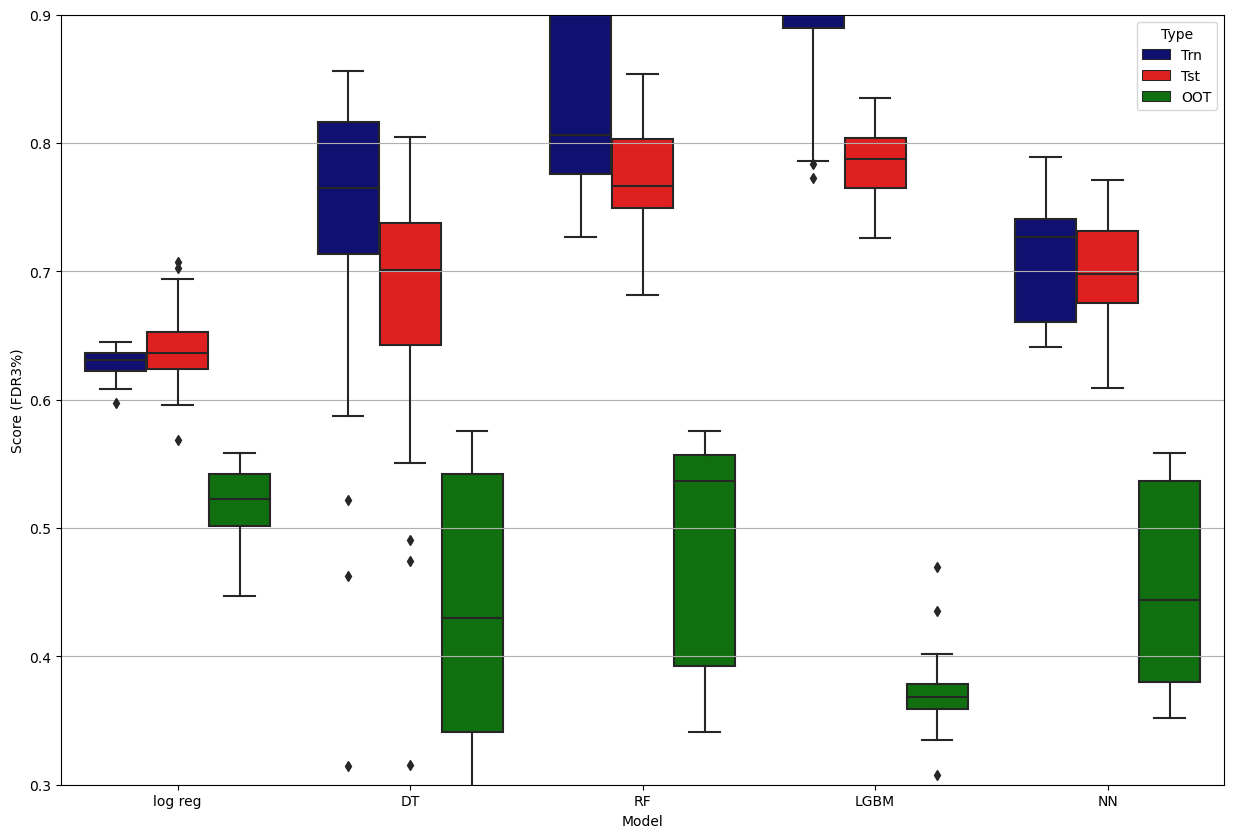

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.3,.9)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [102]:
print('duration: ', datetime.now() - start_time)

duration:  1:53:28.904337


0 0.5561056105610561 0.5656934306569343 0.36312849162011174
1 0.5546623794212219 0.5387596899224806 0.3854748603351955
2 0.5774193548387097 0.5538461538461539 0.3854748603351955
3 0.5435816164817749 0.6144578313253012 0.37988826815642457
4 0.5453020134228188 0.5140845070422535 0.3743016759776536
5 0.5551948051948052 0.6060606060606061 0.3854748603351955
6 0.565359477124183 0.582089552238806 0.3854748603351955
7 0.5638977635782748 0.5354330708661418 0.3687150837988827
8 0.5483359746434231 0.5903614457831325 0.36312849162011174
9 0.5655737704918032 0.562962962962963 0.3854748603351955
loop trn tst oot 1 0.557543276575807 0.5663749250704774 0.3776536312849162
0 1.0 0.842741935483871 0.3687150837988827
1 1.0 0.825925925925926 0.3854748603351955
2 1.0 0.7983539094650206 0.36312849162011174
3 1.0 0.8 0.3575418994413408
4 1.0 0.848605577689243 0.5083798882681564
5 1.0 0.8089430894308943 0.41899441340782123
6 1.0 0.8527131782945736 0.33519553072625696
7 1.0 0.8395061728395061 0.357541899441340

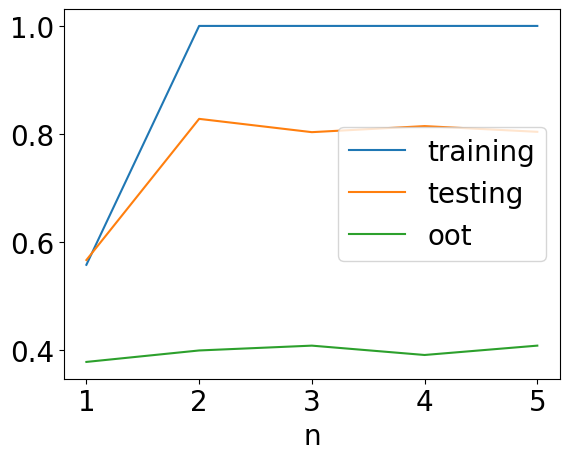

CPU times: user 2min 14s, sys: 332 ms, total: 2min 15s
Wall time: 2min 15s


In [132]:
%%time
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])

for i in range(1,101,20):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#         model = MLPClassifier(hidden_layer_sizes=(i,i))
#         model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i, 
#                                    min_samples_leaf=100, min_samples_split=50)
#         model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=30, max_depth=i, 
#                                learning_rate=0.1, n_estimators=100)
#         model = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=i) 
# #                                    min_samples_leaf=i, min_samples_split=100)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
# plt.savefig('complexity_NN.pdf', format='pdf')
plt.savefig('complexity_RF.pdf', format='pdf')
plt.show()

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [115]:
%%time

for niter in range(100):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                   min_samples_leaf=100, min_samples_split=50)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR3.loc[niter, 'oot'] > .55): break
    
model_counter = model_counter + 1

0 0.7889447236180904 0.7208480565371025 0.5642458100558659
CPU times: user 540 ms, sys: 24.1 ms, total: 564 ms
Wall time: 562 ms


In [116]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [117]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60,predicted,Fraud
84688,2.830476,1.749219,1.258204,1.639680,1.730763,1.366627,1.366550,0.774142,1.625895,1.729681,0.845679,0
89183,9.722223,7.148446,1.176766,0.793514,7.013345,1.191749,1.454852,1.742342,0.144831,7.011174,0.845679,1
89114,6.341771,2.844300,1.055899,0.893042,2.778581,1.069004,1.241456,0.712811,-0.014432,2.777283,0.845679,1
89049,2.673222,2.844300,0.998608,0.793514,2.778581,1.010821,1.132184,1.277399,0.787537,2.777283,0.845679,1
89055,2.954419,2.844300,0.996404,0.893042,2.778581,1.008583,1.113932,1.256990,0.886147,2.777283,0.845679,1
89057,3.313470,2.844300,1.028780,0.992571,2.778581,1.041462,1.146056,1.292910,0.984757,2.777283,0.845679,1
89112,5.838117,2.844300,1.003920,1.168981,0.774988,1.016216,0.710333,-0.190156,0.687814,0.774103,0.845679,1
86085,3.475693,1.749219,1.246301,1.639680,1.730763,1.319334,1.319262,0.788957,-0.233355,1.729681,0.845679,0
89060,3.537990,2.844300,1.001603,0.893042,2.778581,1.013864,1.099718,1.241097,0.886147,2.777283,0.845679,1
89174,9.315610,7.148446,1.161467,0.742253,7.013345,1.176212,1.445630,1.728709,0.095302,7.011174,0.845679,1


In [118]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,124.0,80.0,44.0,64.516129,35.483871,124.0,80.0,44.0,0.653168,24.581006,23.927838,1.818182
2,2.0,125.0,93.0,32.0,74.400000,25.600000,249.0,173.0,76.0,1.412476,42.458101,41.045625,2.276316
3,3.0,124.0,99.0,25.0,79.838710,20.161290,373.0,272.0,101.0,2.220771,56.424581,54.203810,2.693069
4,4.0,124.0,120.0,4.0,96.774194,3.225806,497.0,392.0,105.0,3.200523,58.659218,55.458695,3.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,124.0,124.0,0.0,100.000000,0.000000,11930.0,11751.0,179.0,95.942195,100.000000,4.057805,65.648045
97,97.0,124.0,124.0,0.0,100.000000,0.000000,12054.0,11875.0,179.0,96.954605,100.000000,3.045395,66.340782
98,98.0,124.0,124.0,0.0,100.000000,0.000000,12178.0,11999.0,179.0,97.967015,100.000000,2.032985,67.033520
99,99.0,125.0,125.0,0.0,100.000000,0.000000,12303.0,12124.0,179.0,98.987590,100.000000,1.012410,67.731844


Max possible savings: 20,976,000.0


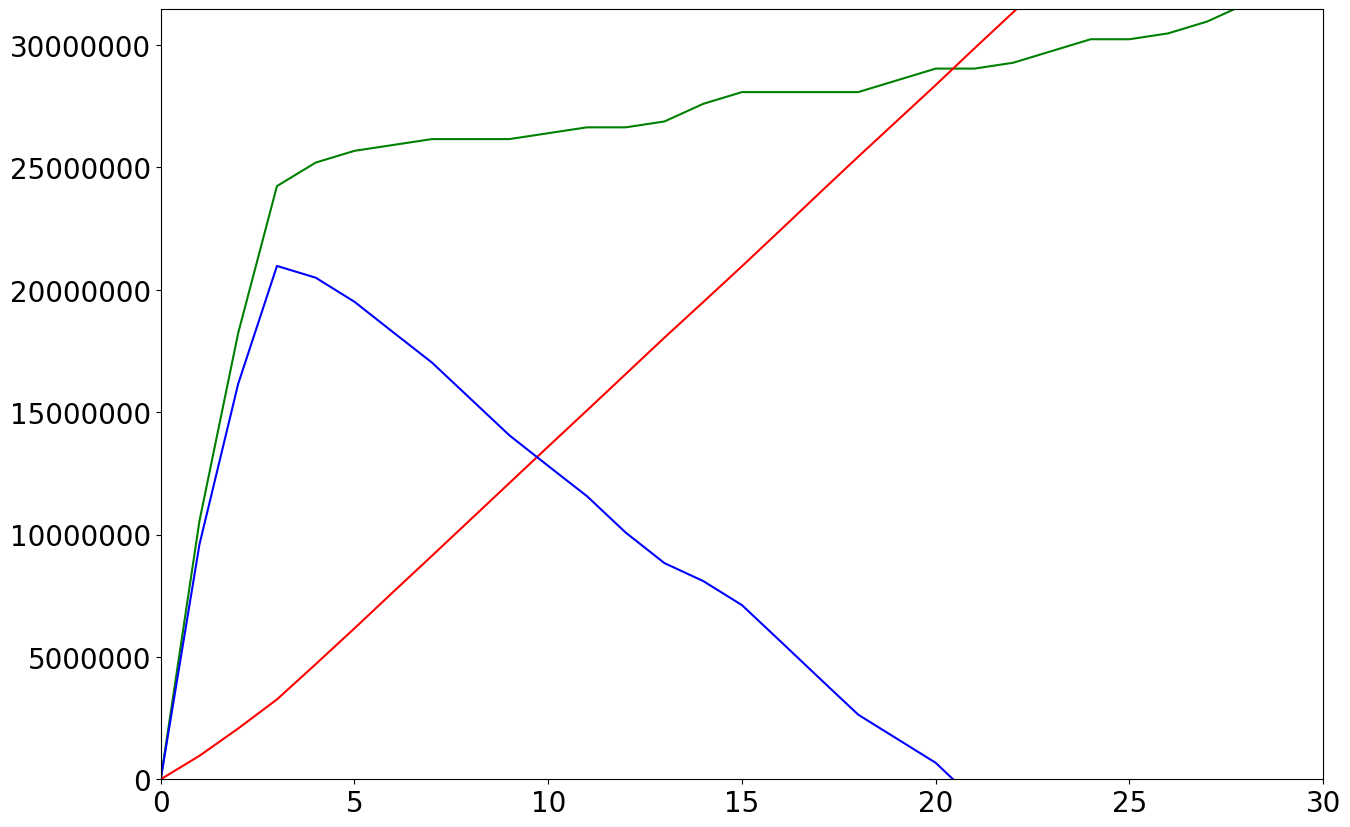

In [119]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [120]:
FDR3.to_csv('FDR3.csv')

In [121]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [122]:
print("duration: ", datetime.now() - start_time)

duration:  2:31:57.815108


In [ ]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

In [ ]:
df['prediction'] = model.predict_proba(X)[:,1]

In [ ]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

In [ ]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

In [ ]:
bads['Merchnum'].value_counts().head(15)

In [ ]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [ ]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

In [ ]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [ ]:
tsample.head(40)

In [ ]:
print("duration: ", datetime.now() - start_time)